In [10]:
sequence_size = 10
input_width = 160
input_height = 100
channels = 2
class_number = 12
data_path = "D:\\Python\\Wormax_learn2\\preprocessed_data_local_notshuffled_2ch\\"

In [11]:
from keras.models import Sequential, Model
from keras import layers, Input
import keras.backend as K

def actual_acc(y_true, y_pred):
    return K.equal(K.argmax(y_pred), K.argmax(y_true))
        
def convolution_feature_extractor(input_height, input_width, channels):
    input_tensor = Input(shape=(input_height, input_width, channels))
    
    x = layers.Conv2D(32, (3, 3), activation='relu')(input_tensor)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    #x = layers.Dropout(0.5)(x)
    output_tensor = layers.Dense(512, activation='relu')(x)
    
    model = Model(input_tensor, output_tensor)    
    model.summary()
    return model

def define_model():
    input_tensor = Input(shape=(sequence_size, input_height, input_width, channels))
        
    x = layers.TimeDistributed(
            convolution_feature_extractor(input_height, input_width, channels))(input_tensor)
    x = layers.GRU(32,
    #        dropout=0.1,
    #        recurrent_dropout=0.5,
            return_sequences=True
                  )(x)
    x = layers.GRU(64, activation='relu',
    #        dropout=0.1,
    #        recurrent_dropout=0.5
                  )(x)
    
    output_tensor = layers.Dense(class_number, activation='softmax')(x)
    model = Model(input_tensor, output_tensor)
   
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
                  metrics=[actual_acc])
    
    model.summary()
    return model

In [12]:
model = define_model()
model.load_weights('worm1.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 100, 160, 2)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 98, 158, 32)       608       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 49, 79, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 47, 77, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 23, 38, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 21, 36, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 10, 18, 128)       0         
__________

In [13]:
from screen_consts import WIDTH, HEIGHT, get_coordinates_from_direction
from grabscreen import grab_screen
from image_preproc import preproc_img
from getkeys import key_check
from image_preproc import prepare_image
import win32api, win32con
import time
import numpy as np
from IPython.display import clear_output

def mouse_down(x,y):
    win32api.SetCursorPos((x,y))
    win32api.mouse_event(win32con.MOUSEEVENTF_LEFTDOWN, x, y, 0, 0)

def mouse_up(x, y):
    win32api.SetCursorPos((x, y))
    win32api.mouse_event(win32con.MOUSEEVENTF_LEFTUP, x, y, 0, 0)

def get_image():
    img = grab_screen()
    img = preproc_img(img)
    prep_img = prepare_image(img).reshape(HEIGHT, WIDTH,2)
    return prep_img

class_number = 12
img = grab_screen()
scr_W, scr_H = len(img[0]), len(img)


print("Start/Pause action with Alt+T")
paused = True

sequence = np.zeros((sequence_size, input_height, input_width, channels))
for i in range(sequence_size):
    sequence[i] = get_image()
    
while True:
    keys = key_check()
    if "ALT" in keys and "T" in keys:
        paused ^= 1
        if paused:
            print("Stop action, press Alt+T to continue")
        else:
            print("Start action in 3 sec.")
            for i in list(range(3))[::-1]:
                time.sleep(1)
                print(i + 1)
            print("action!")
        time.sleep(1)
    if "C" in keys:
        offset = -75
        mouse_up(scr_W//2, scr_H//2+offset)
        mouse_down(scr_W//2, scr_H//2+offset)
        mouse_up(scr_W//2, scr_H//2+offset)
        
    sequence = np.concatenate((sequence[1:], get_image().reshape(1,input_height, input_width,channels)))
        
    if not paused:                
        sequence_reshaped = sequence.reshape(-1, sequence_size, input_height, input_width, channels)
        print(model.predict(sequence_reshaped))
        prediction = np.argmax(model.predict(sequence_reshaped))
        x, y = get_coordinates_from_direction(prediction, scr_W, scr_H, class_number)
        #mouse_up(x, y)
        #print(np.round(model.predict(prep_img), 2), prediction)


Start/Pause action with Alt+T
Start action in 3 sec.
3
2
1
action!
[[0.1756255  0.08009969 0.04422302 0.03234524 0.04921264 0.09565929
  0.14473422 0.08571491 0.05422877 0.04456545 0.0641275  0.12946379]]
[[0.1756255  0.08009969 0.04422302 0.03234524 0.04921264 0.09565929
  0.14473422 0.08571491 0.05422877 0.04456545 0.0641275  0.12946379]]
[[0.1756255  0.08009969 0.04422302 0.03234524 0.04921264 0.09565929
  0.14473422 0.08571491 0.05422877 0.04456545 0.0641275  0.12946379]]
[[0.1756255  0.08009969 0.04422302 0.03234524 0.04921264 0.09565929
  0.14473422 0.08571491 0.05422877 0.04456545 0.0641275  0.12946379]]
[[0.1756255  0.08009969 0.04422302 0.03234524 0.04921264 0.09565929
  0.14473422 0.08571491 0.05422877 0.04456545 0.0641275  0.12946379]]
[[0.1756255  0.08009969 0.04422302 0.03234524 0.04921264 0.09565929
  0.14473422 0.08571491 0.05422877 0.04456545 0.0641275  0.12946379]]
[[0.1756255  0.08009969 0.04422302 0.03234524 0.04921264 0.09565929
  0.14473422 0.08571491 0.05422877 0.

[[0.1756255  0.08009969 0.04422302 0.03234524 0.04921264 0.09565929
  0.14473422 0.08571491 0.05422877 0.04456545 0.0641275  0.12946379]]
[[0.1756255  0.08009969 0.04422302 0.03234524 0.04921264 0.09565929
  0.14473422 0.08571491 0.05422877 0.04456545 0.0641275  0.12946379]]
[[0.1756255  0.08009969 0.04422302 0.03234524 0.04921264 0.09565929
  0.14473422 0.08571491 0.05422877 0.04456545 0.0641275  0.12946379]]
[[0.1756255  0.08009969 0.04422302 0.03234524 0.04921264 0.09565929
  0.14473422 0.08571491 0.05422877 0.04456545 0.0641275  0.12946379]]
[[0.1756255  0.08009969 0.04422302 0.03234524 0.04921264 0.09565929
  0.14473422 0.08571491 0.05422877 0.04456545 0.0641275  0.12946379]]
[[0.1756255  0.08009969 0.04422302 0.03234524 0.04921264 0.09565929
  0.14473422 0.08571491 0.05422877 0.04456545 0.0641275  0.12946379]]
[[0.1756255  0.08009969 0.04422302 0.03234524 0.04921264 0.09565929
  0.14473422 0.08571491 0.05422877 0.04456545 0.0641275  0.12946379]]
[[0.1756255  0.08009969 0.04422302

[[0.1756255  0.08009969 0.04422302 0.03234524 0.04921264 0.09565929
  0.14473422 0.08571491 0.05422877 0.04456545 0.0641275  0.12946379]]
[[0.1756255  0.08009969 0.04422302 0.03234524 0.04921264 0.09565929
  0.14473422 0.08571491 0.05422877 0.04456545 0.0641275  0.12946379]]
[[0.1756255  0.08009969 0.04422302 0.03234524 0.04921264 0.09565929
  0.14473422 0.08571491 0.05422877 0.04456545 0.0641275  0.12946379]]
[[0.1756255  0.08009969 0.04422302 0.03234524 0.04921264 0.09565929
  0.14473422 0.08571491 0.05422877 0.04456545 0.0641275  0.12946379]]
[[0.1756255  0.08009969 0.04422302 0.03234524 0.04921264 0.09565929
  0.14473422 0.08571491 0.05422877 0.04456545 0.0641275  0.12946379]]
[[0.1756255  0.08009969 0.04422302 0.03234524 0.04921264 0.09565929
  0.14473422 0.08571491 0.05422877 0.04456545 0.0641275  0.12946379]]
[[0.1756255  0.08009969 0.04422302 0.03234524 0.04921264 0.09565929
  0.14473422 0.08571491 0.05422877 0.04456545 0.0641275  0.12946379]]
[[0.1756255  0.08009969 0.04422302

KeyboardInterrupt: 

# VIEW INPUT

<IPython.core.display.Javascript object>


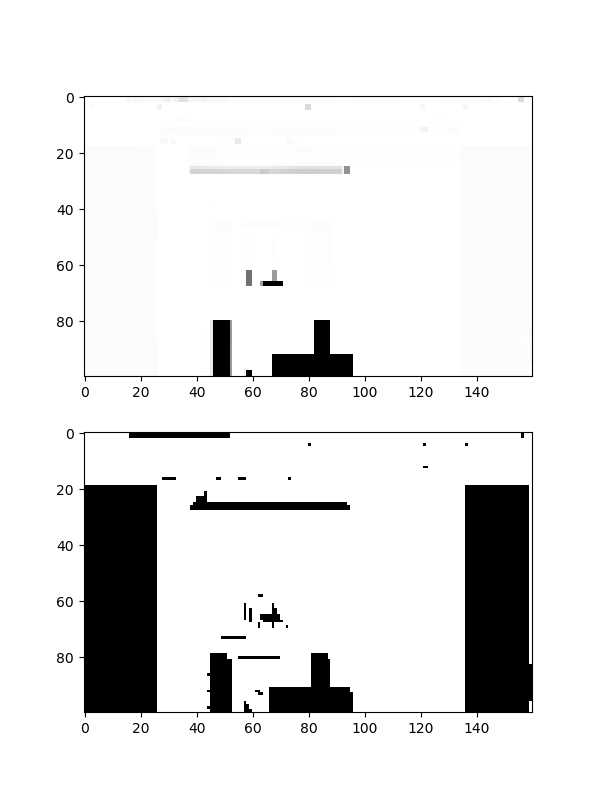

In [10]:
%matplotlib notebook
import cv2
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def grab_frame(channel):
    return prepare_image(preproc_img(grab_screen())).reshape(HEIGHT, WIDTH,2)[:,:,channel]

#create two subplots
gridsize = (2, 1)
fig = plt.figure(figsize=(6, 8))
ax1 = plt.subplot2grid(gridsize, (0, 0))
ax2 = plt.subplot2grid(gridsize, (1, 0))

#create two image plots
im1 = ax1.imshow(grab_frame(0), cmap='Greys_r')
im2 = ax2.imshow(grab_frame(1), cmap='Greys_r')

def update(i):    
    im1.set_data(grab_frame(0))
    im2.set_data(grab_frame(1))

ani = FuncAnimation(plt.gcf(), update, interval=10)
plt.show()